# Project Introduction

This project involves training two generative models: **Variational Autoencoders (VAE)** and **Conditional Variational Autoencoders (CVAE)**.

## Objective

The primary objectives of this project are:
1. To evaluate the performance of the VAE and CVAE models on an image dataset.
2. To compare their outputs in terms of:
   - Reconstruction quality
   - Generative capability


## Variational Autoencoder (VAE)

### Key Features:
- **Encodes** input data into a latent space representation.
- **Decodes** the latent space back into the original data.

### Mathematical Formulation:
- **Encoder**:
  $$ q_\phi(z|x) $$ 
  approximates the posterior distribution.

- **Decoder**:
  $$ p_\theta(x|z) $$ 
  reconstructs data from latent variable \( z \).

### Loss Function:
The total loss for the VAE is the sum of the **reconstruction loss** and the **KL divergence loss**, weighted by a factor \( \beta \):
$$
\mathcal{L}_{\text{VAE}} = \mathcal{L}_{\text{recon}} + \beta \cdot \mathcal{L}_{\text{KL}}
$$


## Conditional Variational Autoencoder (CVAE)

### Key Features:
- **Extends** VAE by conditioning on additional information (e.g., labels \( y \)).
- **Useful** for tasks where controlled data generation is required.

### Mathematical Formulation:
- **Encoder**:
  $$
  q_\phi(z|x, y)
  $$
  *Approximates the posterior distribution conditioned on both input \(x\) and label \(y\).*

- **Decoder**:
  $$
  p_\theta(x|z, y)
  $$
  *Reconstructs input \(x\) from the latent variable \(z\), conditioned on the label \(y\).*


### Loss Function:
The total loss for the CVAE incorporates the conditional reconstruction and KL divergence:
$$
\mathcal{L}_{\text{CVAE}} = \mathcal{L}_{\text{recon}}(x|y) + \beta \cdot \mathcal{L}_{\text{KL}}(z|y)
$$



In [ ]:
import os
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T 
import torch.nn.functional as F


from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import random_split, DataLoader
from torch import nn
from PIL import Image

from models.vae import VAE 
from models.cvae import CVAE

In [27]:
dataset_path = '/Users/lilitasminian/Desktop/DL_project/dataset/Art_Images'

### First we need to check if the dimention of all images in the dataset are equal

In [71]:
def get_image_dimensions(image_paths):
    """
    Prints the dimensions of all images in the dataset and checks if they are consistent.
    """
    dimensions = []
    for img_path in image_paths:
        try:
            with Image.open(img_path) as img:
                dimensions.append(img.size)
        except Exception as e:
            print(f"Error reading {img_path}: {e}")
    return dimensions

valid_image_paths = []

# Collect valid image paths
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        file_path = os.path.join(root, file)
        try:
            img = Image.open(file_path)
            img.verify()
            valid_image_paths.append(file_path)
        except (IOError, SyntaxError):
            print(f"Invalid image detected and skipped: {file_path}")

dimensions = get_image_dimensions(valid_image_paths)

# Print dataset dimensions and check consistency
if dimensions:
    unique_dimensions = set(dimensions)
    print(f"Unique image dimensions in the dataset: {unique_dimensions}")
    if len(unique_dimensions) > 1:
        print("Warning: Not all images have the same dimensions!")
    else:
        print(f"All images have the same dimensions: {unique_dimensions.pop()}")
else:
    print("No valid images found in the dataset.")


Invalid image detected and skipped: /Users/lilitasminian/Desktop/DL_project/dataset/Art_Images/.DS_Store
Invalid image detected and skipped: /Users/lilitasminian/Desktop/DL_project/dataset/Art_Images/training_set/.DS_Store
Invalid image detected and skipped: /Users/lilitasminian/Desktop/DL_project/dataset/Art_Images/training_set/iconography/331.jpg
Invalid image detected and skipped: /Users/lilitasminian/Desktop/DL_project/dataset/Art_Images/training_set/iconography/69.jpg
Invalid image detected and skipped: /Users/lilitasminian/Desktop/DL_project/dataset/Art_Images/validation_set/.DS_Store
Unique image dimensions in the dataset: {(400, 348), (290, 216), (950, 671), (400, 613), (360, 540), (455, 320), (650, 1053), (502, 480), (272, 320), (428, 567), (630, 522), (290, 108), (712, 1000), (849, 709), (280, 180), (530, 700), (290, 373), (461, 600), (257, 196), (800, 560), (597, 875), (264, 320), (290, 229), (600, 800), (184, 184), (410, 410), (477, 320), (514, 733), (310, 408), (290, 350),

Since VAEs typically require consistent input dimensions, we must preprocess the dataset to ensure all images have the same size.

In [74]:
def check_image_dimensions(data_loader):
    """
    Check the dimensions of all images in the DataLoader.
    Args:
        data_loader: PyTorch DataLoader containing the dataset.
    Returns:
        unique_dimensions: Set of unique dimensions in the dataset.
    """
    unique_dimensions = set()

    for images in data_loader:
        batch_dimensions = images.shape[1:]  # Skip batch size
        unique_dimensions.add(batch_dimensions)

    return unique_dimensions

train_dims = check_image_dimensions(train_loader)
val_dims = check_image_dimensions(val_loader)
test_dims = check_image_dimensions(test_loader)

print(f"Unique dimensions in training set: {train_dims}")
print(f"Unique dimensions in validation set: {val_dims}")
print(f"Unique dimensions in test set: {test_dims}")

if len(train_dims) == 1 and len(val_dims) == 1 and len(test_dims) == 1:
    print("All images have consistent dimensions across all splits.")
else:
    print("Warning: Some images have inconsistent dimensions!")

Unique dimensions in training set: {torch.Size([3, 64, 64])}
Unique dimensions in validation set: {torch.Size([3, 64, 64])}
Unique dimensions in test set: {torch.Size([3, 64, 64])}
All images have consistent dimensions across all splits.


In [6]:
class ImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        try:
            img_path = self.image_paths[idx]
            image = Image.open(img_path).convert("RGBA")  # Convert to RGBA to handle transparency
            # Remove transparency by compositing on a white background
            background = Image.new("RGBA", image.size, (255, 255, 255, 255))  # White background
            image = Image.alpha_composite(background, image).convert("RGB")  # Composite and convert to RGB
            if self.transform:
                image = self.transform(image)
            return image
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            return None

In [ ]:
hparams = {
    "input_size": (3, 64, 64),
    "latent_size": 32,
    "batch_size": 64,
    "num_epochs": 20,
    "learning_rate": 1e-4,
    "beta": 1.0,  # Maximum beta for KL divergence
    "use_bce": True,
}

In [ ]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    transforms.RandomResizedCrop((64, 64), scale=(0.7, 1.0)),
    transforms.GaussianBlur(3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])



val_test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])


In [ ]:
dataset = ImageDataset(valid_image_paths, transform=train_transform)

train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_test_transform
test_dataset.dataset.transform = val_test_transform 

train_loader = DataLoader(train_dataset, batch_size=hparams["batch_size"], shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=hparams["batch_size"], shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=hparams["batch_size"], shuffle=False, num_workers=0)

print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}, Testing samples: {len(test_dataset)}")


Training samples: 6860, Validation samples: 857, Testing samples: 859


### Let's display some images to see what we're working with

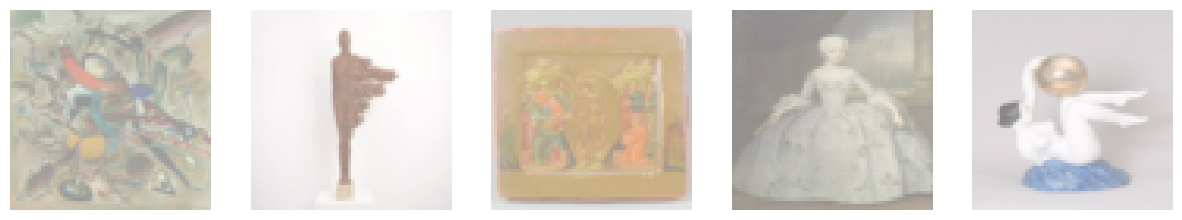

In [ ]:
images = next(iter(train_loader))

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    img = images[i].permute(1, 2, 0)
    img = (img * 0.5 + 0.5).clamp(0, 1)
    axes[i].imshow(img)
    axes[i].axis("off")
plt.show()

# Variational Autoencoder (VAE)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(input_size=hparams["input_size"], latent_size=128).to(device)

In [ ]:
def train_vae(model, train_loader, val_loader, hparams):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    optimizer = Adam(model.parameters(), lr=hparams["learning_rate"], weight_decay=1e-5)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

    training_losses, validation_losses = [], []
    kl_losses_train, recon_losses_train = [], []
    kl_losses_val, recon_losses_val = [], []

    for epoch in range(hparams["num_epochs"]):
        model.train()
        total_train_loss, total_kl_train, total_recon_train = 0, 0, 0

        # Beta Annealing
        beta = min(hparams["beta"], epoch / 100 * hparams["beta"])

        for images in train_loader:
            images = images.to(device)
            optimizer.zero_grad()

            # Forward pass
            reconstructed, mu, logvar = model(images)

            # Reconstruction Loss
            reconstruction_loss = F.mse_loss(reconstructed, images, reduction='sum')

            # KL Divergence Loss
            kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

            # Total loss
            loss = reconstruction_loss + beta * kl_divergence
            total_train_loss += loss.item()
            total_kl_train += kl_divergence.item()
            total_recon_train += reconstruction_loss.item()

            # Backpropagation
            loss.backward()
            optimizer.step()

        avg_train_loss = total_train_loss / len(train_loader.dataset)
        avg_kl_train = total_kl_train / len(train_loader.dataset)
        avg_recon_train = total_recon_train / len(train_loader.dataset)

        training_losses.append(avg_train_loss)
        kl_losses_train.append(avg_kl_train)
        recon_losses_train.append(avg_recon_train)

        # Validation phase
        model.eval()
        total_val_loss, total_kl_val, total_recon_val = 0, 0, 0
        with torch.no_grad():
            for images in val_loader:
                images = images.to(device)
                reconstructed, mu, logvar = model(images)

                reconstruction_loss = F.mse_loss(reconstructed, images, reduction='sum')
                kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
                val_loss = reconstruction_loss + beta * kl_divergence

                total_val_loss += val_loss.item()
                total_kl_val += kl_divergence.item()
                total_recon_val += reconstruction_loss.item()

        avg_val_loss = total_val_loss / len(val_loader.dataset)
        avg_kl_val = total_kl_val / len(val_loader.dataset)
        avg_recon_val = total_recon_val / len(val_loader.dataset)

        validation_losses.append(avg_val_loss)
        kl_losses_val.append(avg_kl_val)
        recon_losses_val.append(avg_recon_val)

        print(f"Epoch [{epoch+1}/{hparams['num_epochs']}], "
              f"Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, "
              f"KL Train: {avg_kl_train:.4f}, Recon Train: {avg_recon_train:.4f}, "
              f"KL Val: {avg_kl_val:.4f}, Recon Val: {avg_recon_val:.4f}, Beta: {beta:.2f}")

        scheduler.step(avg_val_loss)

    return training_losses, validation_losses, kl_losses_train, recon_losses_train, kl_losses_val, recon_losses_val


Epoch [1/20], Training Loss: 727.2758, Validation Loss: 480.9036, KL Train: 1042.8745, Recon Train: 727.2758, KL Val: 755.8795, Recon Val: 480.9036, Beta: 0.00
Epoch [2/20], Training Loss: 374.4724, Validation Loss: 283.2362, KL Train: 490.0255, Recon Train: 369.5721, KL Val: 443.5441, Recon Val: 278.8007, Beta: 0.01
Epoch [3/20], Training Loss: 256.1800, Validation Loss: 223.5524, KL Train: 392.3540, Recon Train: 248.3329, KL Val: 380.6689, Recon Val: 215.9391, Beta: 0.02
Epoch [4/20], Training Loss: 216.3949, Validation Loss: 196.5556, KL Train: 347.8893, Recon Train: 205.9582, KL Val: 343.5112, Recon Val: 186.2503, Beta: 0.03
Epoch [5/20], Training Loss: 195.6235, Validation Loss: 183.9178, KL Train: 318.1322, Recon Train: 182.8982, KL Val: 315.7419, Recon Val: 171.2881, Beta: 0.04
Epoch [6/20], Training Loss: 186.2457, Validation Loss: 174.9472, KL Train: 297.6131, Recon Train: 171.3650, KL Val: 292.9153, Recon Val: 160.3014, Beta: 0.05
Epoch [7/20], Training Loss: 176.3929, Valida

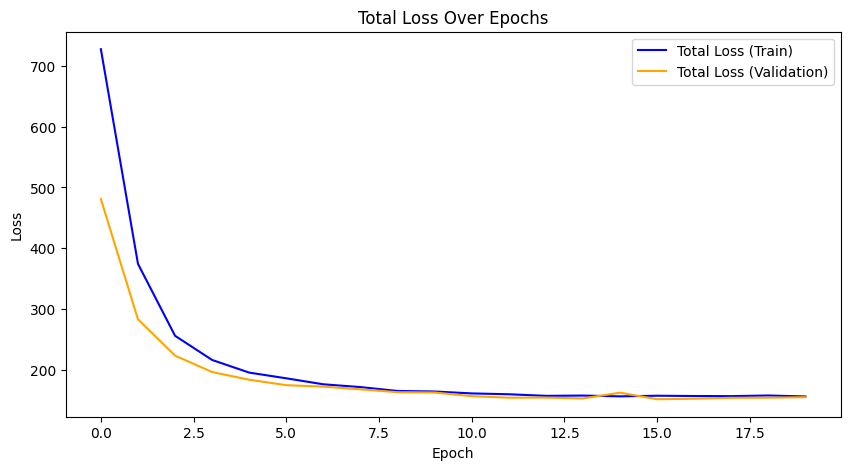

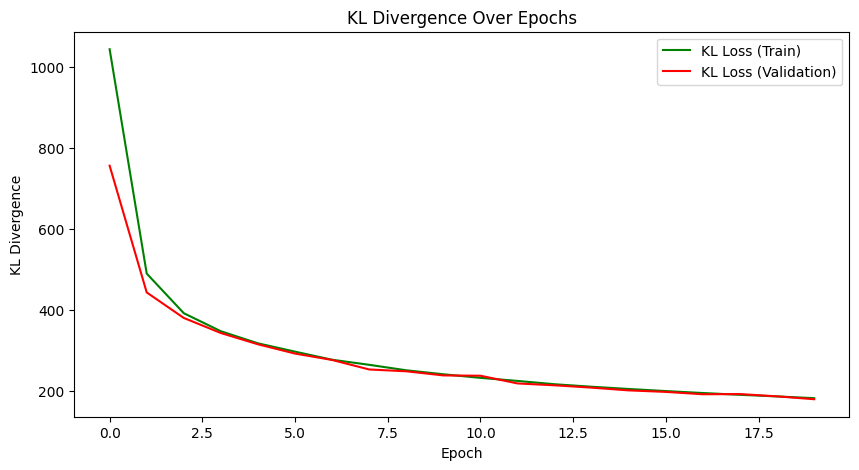

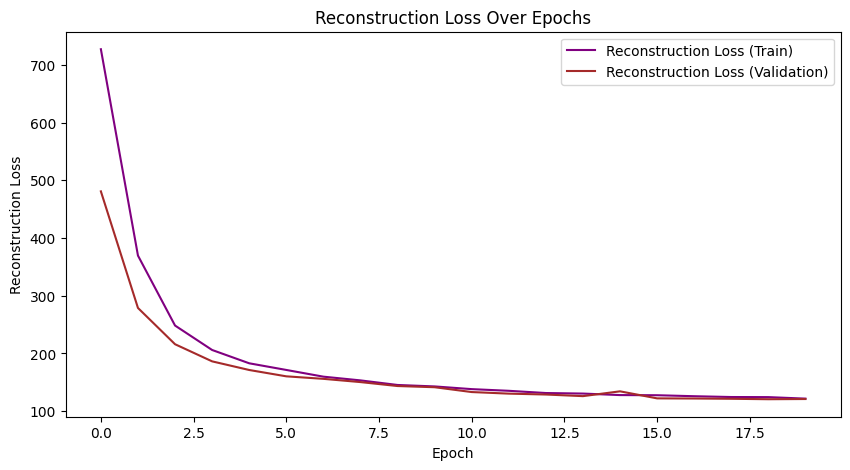

In [62]:
vae_model = VAE(input_size=hparams["input_size"], latent_size=128).to(device)

# Train the model
(training_losses, validation_losses,
 kl_losses_train, recon_losses_train,
 kl_losses_val, recon_losses_val) = train_vae(vae_model, train_loader, val_loader, hparams)

# Plot Total Loss
plt.figure(figsize=(10, 5))
plt.plot(training_losses, label="Total Loss (Train)", color="blue")
plt.plot(validation_losses, label="Total Loss (Validation)", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Total Loss Over Epochs")
plt.legend()
plt.show()

# Plot KL Divergence
plt.figure(figsize=(10, 5))
plt.plot(kl_losses_train, label="KL Loss (Train)", color="green")
plt.plot(kl_losses_val, label="KL Loss (Validation)", color="red")
plt.xlabel("Epoch")
plt.ylabel("KL Divergence")
plt.title("KL Divergence Over Epochs")
plt.legend()
plt.show()

# Plot Reconstruction Loss
plt.figure(figsize=(10, 5))
plt.plot(recon_losses_train, label="Reconstruction Loss (Train)", color="purple")
plt.plot(recon_losses_val, label="Reconstruction Loss (Validation)", color="brown")
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Loss")
plt.title("Reconstruction Loss Over Epochs")
plt.legend()
plt.show()



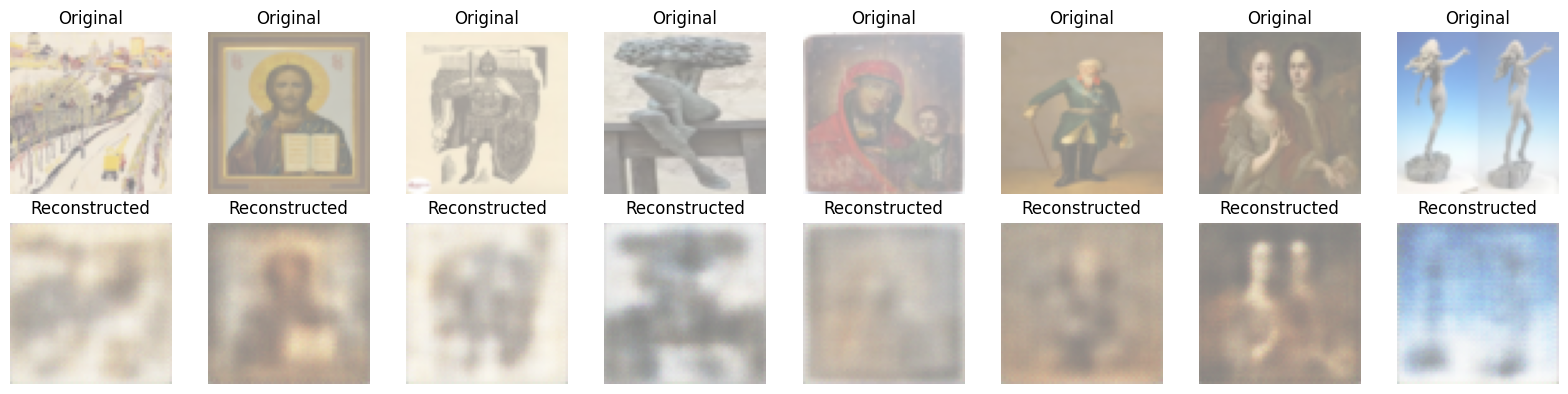

In [ ]:
import matplotlib.pyplot as plt

def show_reconstructed_images(model, data_loader, device, num_images=8):
    """
    Display original and reconstructed images side by side.
    
    Args:
        model: The trained VAE model.
        data_loader: DataLoader containing the dataset to test.
        device: The device on which the model and data reside (e.g., 'cuda' or 'cpu').
        num_images: Number of images to display.
    """
    model.eval()
    images_shown = 0

    with torch.no_grad():
        for images in data_loader:
            images = images.to(device)

            reconstructed, _, _ = model(images)

            images = (images + 1.0) / 2.0 
            reconstructed = (reconstructed + 1.0) / 2.0

            images = images.permute(0, 2, 3, 1).cpu().numpy()
            reconstructed = reconstructed.permute(0, 2, 3, 1).cpu().numpy()

            fig, axs = plt.subplots(2, num_images, figsize=(num_images * 2, 4))

            for i in range(num_images):
                axs[0, i].imshow(images[i])
                axs[0, i].axis('off')
                axs[0, i].set_title("Original")

                axs[1, i].imshow(reconstructed[i])
                axs[1, i].axis('off')
                axs[1, i].set_title("Reconstructed")

            plt.tight_layout()
            plt.show()

            images_shown += num_images
            if images_shown >= num_images:
                break


show_reconstructed_images(vae_model, test_loader, device, num_images=8)


### As we can see from the reconstructed images that the VAE successfully reconstructs the overall structure and colors of the original images, but it struggles with fine details, leading to blurry reconstructions.
### To address these limitations, we will use a Conditional Variational Autoencoder (CVAE). By conditioning the model on additional information, such as class labels or attributes, the CVAE can leverage this auxiliary data to better structure the latent space and improve reconstruction quality.

In [ ]:
#Save the original and reconstrcuted images

output_dir = "vae_outputs"
os.makedirs(output_dir, exist_ok=True)

# Filepaths
model_path = os.path.join(output_dir, "vae_model.pth")
reconstructed_images_dir = os.path.join(output_dir, "reconstructed_images")
os.makedirs(reconstructed_images_dir, exist_ok=True)

# Save the model weights
torch.save(vae_model.state_dict(), model_path)
print(f"Model weights saved at: {model_path}")

# Save original and reconstructed images
def save_reconstructed_images(model, data_loader, device, save_dir, num_images=8):
    """
    Save original and reconstructed images side by side for later analysis.
    
    Args:
        model: The trained VAE model.
        data_loader: DataLoader containing the dataset to test.
        device: The device on which the model and data reside (e.g., 'cuda' or 'cpu').
        save_dir: Directory to save images.
        num_images: Number of images to save.
    """
    model.eval()
    images_saved = 0

    with torch.no_grad():
        for images in data_loader:
            images = images.to(device)

            # Generate reconstructed images
            reconstructed, _, _ = model(images)

            # Normalize for visualization
            images = (images + 1.0) / 2.0
            reconstructed = (reconstructed + 1.0) / 2.0

            images = images.permute(0, 2, 3, 1).cpu().numpy()
            reconstructed = reconstructed.permute(0, 2, 3, 1).cpu().numpy()

            for i in range(min(num_images - images_saved, images.shape[0])):
                # Save original and reconstructed images
                original_img_path = os.path.join(save_dir, f"original_{images_saved + i + 1}.png")
                reconstructed_img_path = os.path.join(save_dir, f"reconstructed_{images_saved + i + 1}.png")

                plt.imsave(original_img_path, images[i])
                plt.imsave(reconstructed_img_path, reconstructed[i])

                print(f"Saved original: {original_img_path}, reconstructed: {reconstructed_img_path}")

            images_saved += images.shape[0]
            if images_saved >= num_images:
                break

# Save the reconstructed images
save_reconstructed_images(vae_model, test_loader, device, reconstructed_images_dir, num_images=8)
print(f"Reconstructed images saved in: {reconstructed_images_dir}")


Model weights saved at: vae_outputs/vae_model.pth
Saved original: vae_outputs/reconstructed_images/original_1.png, reconstructed: vae_outputs/reconstructed_images/reconstructed_1.png
Saved original: vae_outputs/reconstructed_images/original_2.png, reconstructed: vae_outputs/reconstructed_images/reconstructed_2.png
Saved original: vae_outputs/reconstructed_images/original_3.png, reconstructed: vae_outputs/reconstructed_images/reconstructed_3.png
Saved original: vae_outputs/reconstructed_images/original_4.png, reconstructed: vae_outputs/reconstructed_images/reconstructed_4.png
Saved original: vae_outputs/reconstructed_images/original_5.png, reconstructed: vae_outputs/reconstructed_images/reconstructed_5.png
Saved original: vae_outputs/reconstructed_images/original_6.png, reconstructed: vae_outputs/reconstructed_images/reconstructed_6.png
Saved original: vae_outputs/reconstructed_images/original_7.png, reconstructed: vae_outputs/reconstructed_images/reconstructed_7.png
Saved original: vae

# Conditional Variational Autoencoder (CVAE)